Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.842697374727
            Iterations: 4
            Function evaluations: 24
            Gradient evaluations: 4


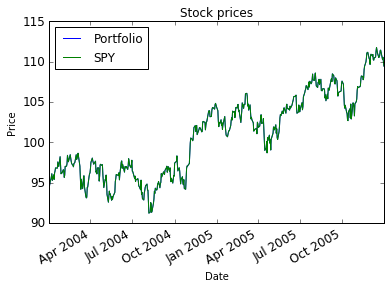

Start Date: 2004-01-01 00:00:00
End Date: 2006-01-01 00:00:00
Symbols: ['AXP', 'HPQ', 'IBM', 'HNZ']
Allocations: [  7.75020866e-01   2.24979134e-01   7.11236625e-17   0.00000000e+00]
Sharpe Ratio: 0.842697374727
Volatility (stdev of daily returns): 0.00932371285728
Average Daily Return: 0.000494948782896
Cumulative Return: 0.255023427433


In [7]:
"""MC1-P2: Optimize a portfolio."""
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from util import get_data, plot_data
import scipy.optimize as spo

# This is the function that will be tested by the autograder
# The student must update this code to properly implement the functionality
def optimize_portfolio(sd=dt.datetime(2008,1,1), ed=dt.datetime(2009,1,1), \
    syms=['GOOG','AAPL','GLD','XOM'], gen_plot=False):

    ######### ASSESS PORTFOLIO
    def assess_portfolio(sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009, 1, 1), \
                     syms=['GOOG', 'AAPL', 'GLD', 'XOM'], \
                     allocs=[0.1, 0.2, 0.3, 0.4], rfr=0.0, sf=252.0):
        import math
        # Read in adjusted closing prices for given symbols, date range
        dates = pd.date_range(sd, ed)
        prices_all = get_data(syms, dates)  # automatically adds SPY
        prices = prices_all[syms]  # only portfolio symbols
        prices_SPY = prices_all['SPY']  # only SPY, for comparison later

        # Get daily portfolio value
        port_val = prices_SPY  # add code here to compute daily portfolio values
        df = prices.copy()
        df[1:] = (df[1:] / df[0:-1].values)
        for j in range(len(allocs)):
            df.ix[0, j] = allocs[j]
            
        allocs = np.asarray([0.2, 0.2, 0.3, 0.3, 0.0]) 

        days = prices.shape[0]
        for i in range(1, days):
            df.ix[i, :] = df.ix[i, :] * df.ix[i - 1, :]
        df['cumm'] = df.sum(axis=1)
        df['daily'] = (df.ix[1:, 'cumm'] / df.ix[0:-1, 'cumm'].values) - 1.
        df['daily_rf'] = df['daily'] - rfr ** (1. / days)
        sr = math.sqrt(sf) * df['daily_rf'].mean() / df['daily_rf'].std()
        cr = df.ix[-1, 'cumm'] - 1
        sddr = df.ix[1:, 'daily'].std()
        adr = df.ix[1:, 'daily'].mean()
        return cr, adr, sddr, sr
    
    def get_negative_sharpe(allocs,prices ):
        import math
        rfr=0.0
        sf=252.0
        df = prices.copy()
        df[1:] = (df[1:] / df[0:-1].values)
        for j in range(len(allocs)):
            df.ix[0, j] = allocs[j]
        
        days = prices.shape[0]
        for i in range(1, days):
            df.ix[i, :] = df.ix[i, :] * df.ix[i - 1, :]
        df['cumm'] = df.sum(axis=1)
        df['daily'] = (df.ix[1:, 'cumm'] / df.ix[0:-1, 'cumm'].values) - 1.
        df['daily_rf'] = df['daily'] - rfr ** (1. / days)
        return math.sqrt(sf) * df['daily_rf'].mean() / df['daily_rf'].std() *-1.0
    
    import scipy.optimize as spo
    
    def min_sharpe(syms,data,error_func):
        # Init the allocations for the optimal portfolio
        allocs = [0.1 for x in syms]
        
        #Says one minus the sum of all variables must be zero
        cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})

        #Required to have non negative values
        bnds = tuple((0.0,1.0) for x in allocs)

        result = spo.minimize(error_func,allocs,args=(data,),method='SLSQP',options={'disp':True},constraints=cons,bounds=bnds)
        return result.x
        
    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)  # automatically adds SPY
    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later
    allocs = min_sharpe(syms,prices,get_negative_sharpe)
    cr, adr, sddr, sr = assess_portfolio(sd = sd, ed = ed,syms = syms, allocs = allocs)

    # Get daily portfolio value
    port_val = prices_SPY # add code here to compute daily portfolio values

    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        df_temp = pd.concat([port_val, prices_SPY], keys=['Portfolio', 'SPY'], axis=1)
        ax = df_temp.plot(title="Stock prices", fontsize=12)
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        plt.show()
        fig = ax.get_figure()
        fig.savefig("comparison_optimal.png")   

    return allocs, cr, adr, sddr, sr

def test_code():
    start_date = dt.datetime(2004,1,1)
    end_date = dt.datetime(2006,1,1)
    symbols = ['AXP', 'HPQ', 'IBM', 'HNZ']

    '''
    Start Date: 2004-01-01
    End Date: 2006-01-01
    Symbols: ['AXP', 'HPQ', 'IBM', 'HNZ']
    Optimal allocations: [  7.75113042e-01   2.24886958e-01  -1.18394877e-16  -7.75204553e-17]
    Sharpe Ratio: 0.842697383626
    Volatility (stdev of daily returns): 0.0093236393828
    Average Daily Return: 0.000494944887734
    Cumulative Return: 0.255021425162
    '''
    
    # Assess the portfolio
    allocations, cr, adr, sddr, sr = optimize_portfolio(sd = start_date, ed = end_date,\
        syms = symbols, \
        gen_plot = True)

    # Print statistics
    print "Start Date:", start_date
    print "End Date:", end_date
    print "Symbols:", symbols
    print "Allocations:", allocations
    print "Sharpe Ratio:", sr
    print "Volatility (stdev of daily returns):", sddr
    print "Average Daily Return:", adr
    print "Cumulative Return:", cr

if __name__ == "__main__":
    test_code()



[ 4.  2.]
C0= 4.0  C1= 2.0
llllll:  [  0.         22.1931076]
data:  [[  0.           7.02936332]
 [  0.5          4.55673248]
 [  1.          10.05885484]
 [  1.5          7.39883473]
 [  2.           5.13599179]
 [  2.5         15.87351494]
 [  3.          15.01188137]
 [  3.5          9.52024338]
 [  4.          21.64083406]
 [  4.5         17.647623  ]
 [  5.          16.48762293]
 [  5.5         28.61161909]
 [  6.          22.0256285 ]
 [  6.5         24.92090308]
 [  7.          26.86698546]
 [  7.5         35.51503637]
 [  8.          38.09930804]
 [  8.5         33.35158598]
 [  9.          40.146016  ]
 [  9.5         39.77269018]
 [ 10.          46.38400398]]
<function error at 0x115e90aa0>
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 288.872575962
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
fitted line C0= 3.98493396846  C1= 2.26844452485


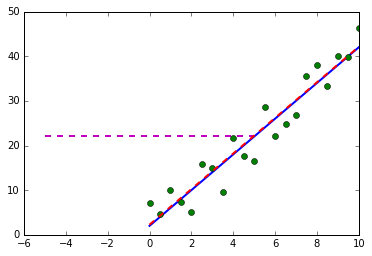

In [36]:
def error(line,data):
    err = np.sum(( data[:,1] - (line[0] * data[:,0] + line[1]) )**2)
    return err

def fit_line(data,error_func):
    l = np.float32([0,np.mean(data[:,1])])
    print 'llllll: ',l
    print 'data: ',data
    x_ends = np.float32([-5,5])
    plt.plot(x_ends,l[0] * x_ends + l[1], 'm--', linewidth=2.0, label='initial guess')
    print error_func
    result = spo.minimize(error_func,l,args=(data,),method='SLSQP',options={'disp':True})
    return result.x
    
l_orig = np.float32([4,2])
print l_orig
print 'C0=',l_orig[0],' C1=',l_orig[1]
Xorig = np.linspace(0,10,21)
Yorig = l_orig[0] * Xorig + l_orig[1]
plt.plot(Xorig,Yorig,'b',linewidth=2.0,label='Original Line')

noise_signma = 3.0
noise = np.random.normal(0,noise_signma,Yorig.shape)
data = np.asarray([Xorig,Yorig+noise]).T
plt.plot(data[:,0],data[:,1],'go',label='data points')

l_fit = fit_line(data,error)
print "fitted line C0=",l_fit[0], " C1=",l_fit[1]
plt.plot(data[:,0], l_fit[0]*data[:,0] + l_fit[1], 'r--',linewidth=2.0, label='fitted line')